
#  I. Customer Lifetime Value

### Customer relationships are play crucial role in growth. 
Customer LTV: the metrics to understand the net profit attributed to the entire future relationship between the company and the client. 

The more users consume the product and the longer they continue to use it, the higher the LTV.

#### Example from LTV insight: 

 --- Take some action towards a customer when her probability of being active reaches a certain threshold to prevent churn.

## Using Beta Geometric Negative Binomial Distribution (BG-NBD)

BG/NBD model properties:

1. When a user is active, a number of his or her transactions in a time period of length 't' is described by Poisson distribution with transaction rate λ.

2. Heterogeneity in transaction rate across users (meaning how customers differ in purchasing behavior) has Gamma distribution with parameters 'r' (shape) and 'α' (scale).

3. Users may become inactive after any transaction with probability p and their dropout point (when they become inactive) is distributed between purchases with Geometric distribution.

4. Heterogeneity (variation across users) in dropout probability has Beta distribution with the two shape parameters 'α' and 'β'.

5. Transaction rate and dropout probability independently vary across users.

## BG-NBD focuses on on transaction occurences!

The Greek's:
1.	Poisson distribution helps to predict certain events happening using the data about how often event occurred in past.
2.	Gamma distribution arises naturally in processes with waiting time between Poisson distributed events (as in our case for transaction rate λ).
3.	Geometric distribution is similar to Bernoulli trials and is used for modeling the number of trials up to and including the first success.
4.	Beta distribution is the best for representing a probabilistic distribution of probabilities — the case where we don’t know what a probability is in advance, but we have some reasonable priors, described by α and β (mean of a Beta distribution α / (α+β)).

###### Python Modulde 'Lifetimes':

- estimates if these entities are alive and predicts how much more they will interact based on their history.

## 1. Installation and Loading Data

Load Data from  the Lifetimes package. The data contails the following info on customers:
1. Frequency - the number of repeat purchases the customer has made.
2. Recency - the duration between a customer’s first purchase and their latest purchase.
3. T - the duration between a customer’s first purchase and the end of the period under study.
4. Customer ID

In [4]:
pip install lifetimes

    100% |████████████████████████████████| 583kB 19.1MB/s ta 0:00:01
    100% |████████████████████████████████| 153kB 3.5MB/s ta 0:00:01
  Stored in directory: /Users/zelalemabahana/Library/Caches/pip/wheels/5b/d7/0f/e58eae695403de585269f4e4a94e0cd6ca60ec0c202936fa4a
  Stored in directory: /Users/zelalemabahana/Library/Caches/pip/wheels/72/6f/c2/40f130cca2c91f31d354bf72de282922479c09ce0b7853c4c5
Successfully built dill autograd
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
from lifetimes.datasets import load_cdnow_summary

In [6]:
data = load_cdnow_summary(index_col=[0])

print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86


In [7]:
print(data.describe())

         frequency      recency            T
count  2357.000000  2357.000000  2357.000000
mean      1.042427     6.845787    32.715829
std       2.190014    10.731400     3.326906
min       0.000000     0.000000    27.000000
25%       0.000000     0.000000    29.860000
50%       0.000000     0.000000    32.710000
75%       1.000000    12.000000    35.430000
max      29.000000    38.430000    38.860000


## 2. Frequency/Recency Analysis

Beta Geometric Negative Binomial Distribution (BG_NBD) model. 

Assumptions:

1. While active, transactions made by a customer in time period 't' is Poisson distributed with mean 'λt' 
2. Differences in transaction rate between customers follows a gamma distribution with shape 'r' and scale 'α' 
3. Each customer becomes inactive after each transaction with probability 'p' 
4. Differences in 'p' follows a beta distribution with shape parameters 'a' and 'b'
5. Transaction rate and dropout probability vary independently between customers




In [8]:
from lifetimes import BetaGeoFitter

#similar API to scikit-learn and lifelines

bgf = BetaGeoFitter(penalizer_coef =0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


In [9]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.242593,0.012557,0.217981,0.267205
alpha,4.413532,0.378221,3.672218,5.154846
a,0.792886,0.185719,0.428877,1.156895
b,2.425752,0.705345,1.043276,3.808229


## 3. Visualizing Frequency Recency Matrix

The expected number of transactions an artificial customer is expected to make in the next period

In [10]:
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_frequency_recency_matrix
plot_frequency_recency_matrix(bgf)
plt.show()

<Figure size 640x480 with 2 Axes>

## 4. Probability of Still Being Alive

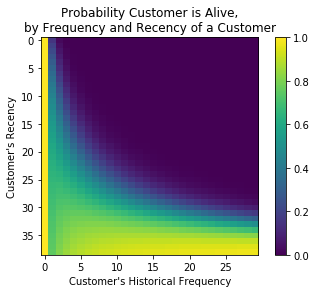

In [11]:
from lifetimes.plotting import plot_probability_alive_matrix
plot_probability_alive_matrix(bgf)

## 5. Ranking Customers (Best to Worst)

Highest expected purchase in the next period

In [12]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(10)

,frequency,recency,T,predicted_purchases
ID,,,,
1017,12,32.43,33.43,0.296308
693,13,34.43,35.00,0.312249
813,13,33.86,34.29,0.318802
1413,14,30.29,31.57,0.360929
1539,14,29.86,30.86,0.371088
509,18,35.14,35.86,0.424877
841,19,34.00,34.14,0.474738
1981,17,28.43,28.86,0.486526
157,29,37.71,38.00,0.662396


## 6. Assessing Model Fit

~ Measured against simulated data

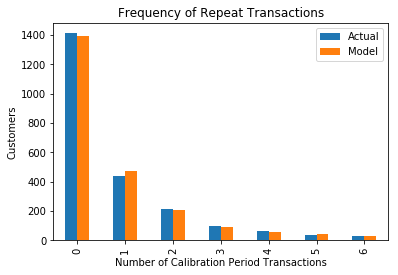

In [13]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

## 7. Model Using Transactional Dataset

Utility function to transform transaction data to summary data (frequency, recency, and age)

In [14]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
print(transaction_data.head())

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2


In [15]:
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end = '2014-12-31')
print(summary.head())

    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


In [16]:
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 1.85, alpha: 1.86, b: 3.18, r: 0.16>

## 8. Model Fitting 
Split transactional data into calibration and holdout periods.

In [17]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date', calibration_period_end = '2014-09-01', observation_period_end = '2014-12-31')
print(summary_cal_holdout.head())

    frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
id                                                                        
0             0.0          0.0  177.0                0.0               121
1             0.0          0.0  103.0                0.0               121
2             6.0        142.0  171.0                0.0               121
3             0.0          0.0   26.0                0.0               121
4             2.0          9.0   62.0                0.0               121


##### Fitting using '_cal' column and and test on the '_holdout' columns

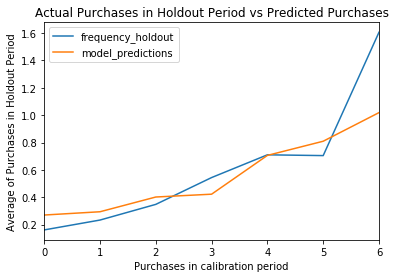

In [18]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'],summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'] )

plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

## 9. Customer Predictions
##### Predict based on customers purchase history 

In [19]:
t = 10 #to predict purchases in 10 periods
individual = summary.iloc[20]

#the below 'predict' function is an alias to 'bgf.conditional_expected_number_of_purchases_up_to_time'
bgf.predict(t, individual['frequency'],individual['recency'], individual['T'])

0.05765116591827167

## 10. Customer Probability Histories 
##### Historical Probability of being Alive

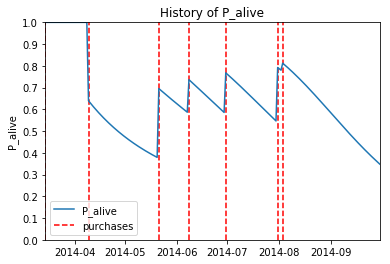

In [20]:
from lifetimes.plotting import plot_history_alive

id = 2 # try 35 2 5 47
days_since_birth = 200
sp_trans = transaction_data.loc[transaction_data['id'] == id]

plot_history_alive(bgf, days_since_birth, sp_trans, 'date')

# II. Customer Lifetime Value Using Gamma-Gamma Model
#####  -- Takes into account the economic value of each transaction


## 1. Estimating Lifetime Value

In [21]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()

returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency'] > 0]
print(returning_customers_summary.head())


             frequency  recency      T  monetary_value
customer_id                                           
1                    2    30.43  38.86           22.35
2                    1     1.71  38.86           11.77
6                    7    29.43  38.86           73.74
7                    1     5.00  38.86           11.77
9                    2    35.71  38.86           25.55


## 2. Independence Assumption

######  -- there is no relationship between the monetary value and the purchase frequency
######       -- check the Pearson correlation is close to zero

In [22]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


## 3. Train the Gamma-Gamma Submodel

In [23]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],returning_customers_summary['monetary_value'])

print(ggf)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>


## 4. Estimate the Average Transaction Value

In [24]:
print(ggf.conditional_expected_average_profit(
    summary_with_money_value['frequency'],summary_with_money_value['monetary_value']).head())

customer_id
1    24.658616
2    18.911480
3    35.171002
4    35.171002
5    35.171002
dtype: float64


In [25]:
print(print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_money_value['frequency'],
        summary_with_money_value['monetary_value']
    ).mean(),
    summary_with_money_value[summary_with_money_value['frequency']>0]['monetary_value'].mean()
)))

Expected conditional average profit: 35.25295817605008, Average profit: 35.07855179704026
None


## 5. Compute the Total CLV using Discounted Cash Flow Method 

##### Refit the BG model to the summary_with_money_value dataset
Applying discount rate of 0.01 (about 12.7% annually)

In [22]:

bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=12, # months
    discount_rate=0.01 
).head(10))


customer_id
1      140.096218
2       18.943466
3       38.180575
4       38.180575
5       38.180575
6     1003.868285
7       28.109681
8       38.180575
9      167.418224
10      38.180575
Name: clv, dtype: float64


# III. Saving and Loading the Model

## 1. Fit the Model

In [23]:
from lifetimes import BetaGeoFitter
from lifetimes.datasets import load_cdnow_summary

data = load_cdnow_summary(index_col=[0])
bgf = BetaGeoFitter()
bgf.fit(data['frequency'], data['recency'], data['T'])
bgf


<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>

## 2. Saving the Model

Model will be saved with dill to 'pickle object'.

In [24]:
bgf.save_model('bgf.pkl')

## 3. Loading model

In [25]:
bgf_loaded = BetaGeoFitter()
bgf_loaded.load_model('bgf.pkl')
bgf_loaded

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>